### Criar um conjunto de modelos preditivos que sejam capazes de prever, a partir de uma série de variáveis fisiológicas, se o paciente apresenta ou não uma alta probabilidade de possuir uma doença hepática. E a partir de tais modelos, selecionar o que possui a melhor performance para ir a produção.

In [1]:
# imports
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

#### Carga de dados

In [2]:
dados = pd.read_csv('dados/dataset.csv')
dados.shape

(583, 11)

In [3]:
dados.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [4]:
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
244,54,Male,0.8,0.2,218,20,19,6.3,2.5,0.6,1
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.0,1
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.0,1
420,55,Female,10.9,5.1,1350,48,57,6.4,2.3,0.5,1
144,45,Female,3.5,1.5,189,63,87,5.6,2.9,1.0,1


#### Análise exploratória

In [5]:
dados.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [6]:
#var. categóricas
dados.dtypes[dados.dtypes == 'object']

Gender    object
dtype: object

In [7]:
#var. numéricas
dados.dtypes[dados.dtypes != 'object']

Age                             int64
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [8]:
dados.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


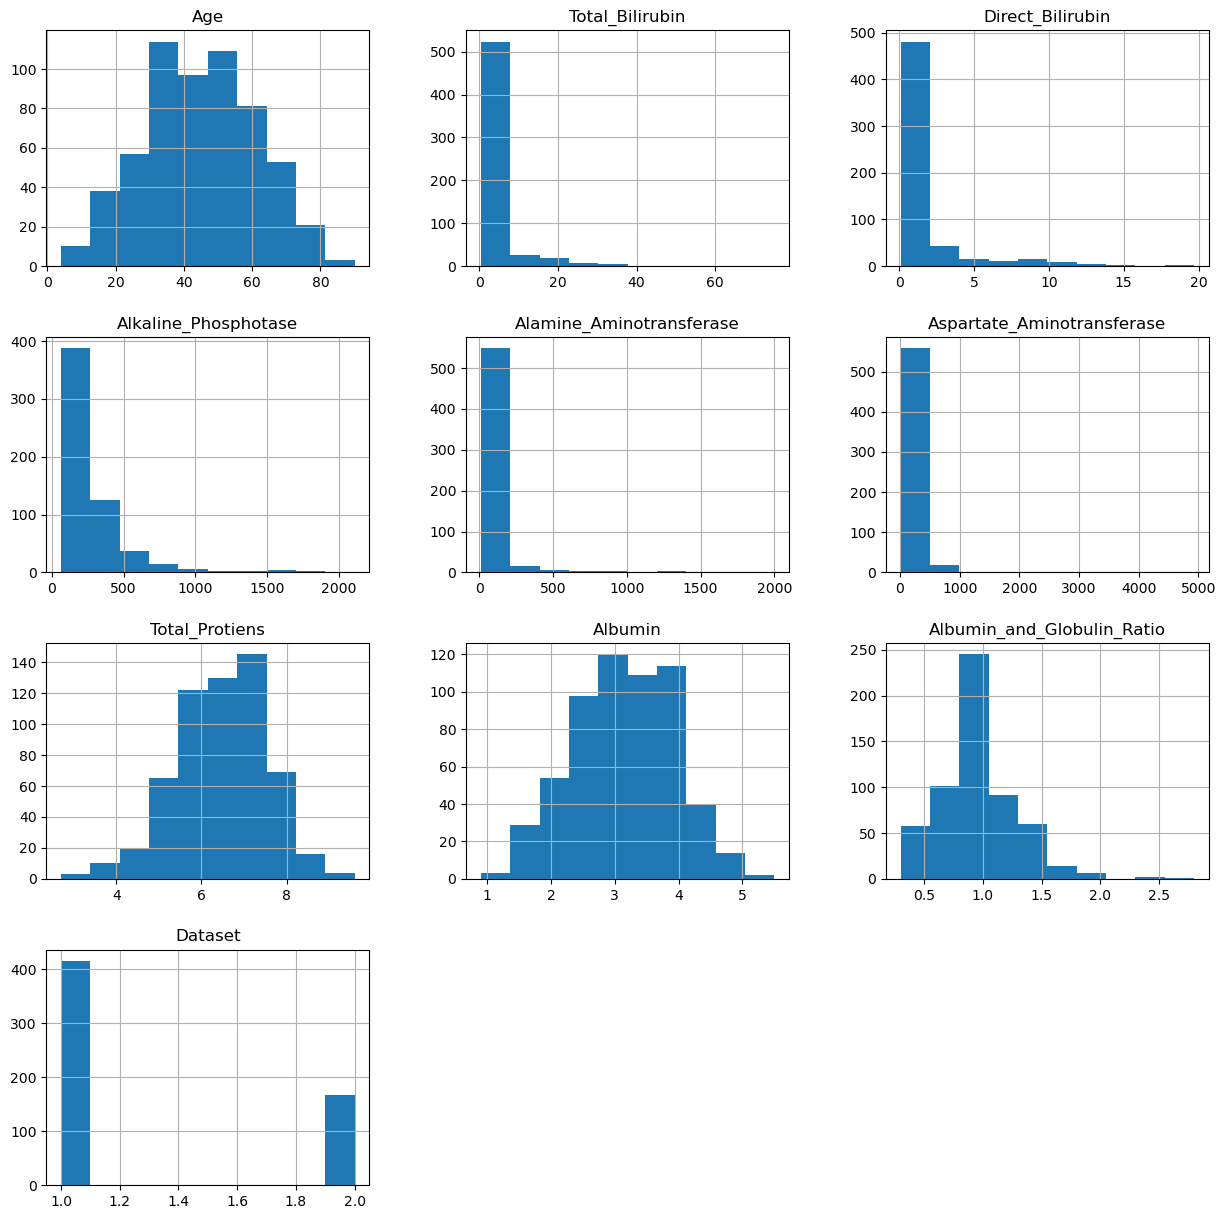

In [9]:
dados.hist(figsize = (15,15), bins = 10) 
plt.show()

In [10]:
# Função para ajuste do encoding da variável target
def ajusta_var(x):
    if x == 2:
        return 0
    return 1

In [11]:
dados['Dataset'] = dados['Dataset'].map(ajusta_var)

In [12]:
# Ajustando nome da var. target
dados.rename({'Dataset':'Target'}, axis = 'columns', inplace = True)

In [13]:
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
535,60,Male,19.6,9.5,466,46,52,6.1,2.0,0.4,1
27,34,Male,6.2,3.0,240,1680,850,7.2,4.0,1.2,1
162,60,Male,5.8,2.7,599,43,66,5.4,1.8,0.5,1
296,74,Female,0.9,0.3,234,16,19,7.9,4.0,1.0,1
504,32,Male,30.5,17.1,218,39,79,5.5,2.7,0.9,1


In [14]:
# Variável categórica
dados.describe(include = ['object'])

,Gender
count,583
unique,2
top,Male
freq,441


Número de pacientes do sexo masculino:  441
Número de pacientes do sexo feminino:  142


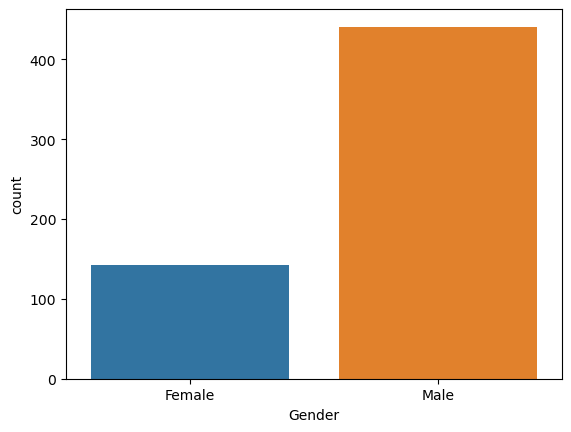

In [15]:
sns.countplot(data = dados, x = 'Gender', label = 'Count')

M, F = dados['Gender'].value_counts()

print('Número de pacientes do sexo masculino: ', M)
print('Número de pacientes do sexo feminino: ', F)

In [16]:
# Label encoding na variável Gender
def encoding_func(x):
    if x == 'Male':
        return 0
    return 1

In [17]:
# Aplica
dados['Gender'] = dados['Gender'].map(encoding_func)

In [18]:
dados.sample(5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
169,60,0,8.9,4.0,950,33,32,6.8,3.1,0.80,1
79,58,1,2.8,1.3,670,48,79,4.7,1.6,0.50,1
422,41,0,1.2,0.5,246,34,42,6.9,3.4,0.97,1
458,26,0,6.8,3.2,140,37,19,3.6,0.9,0.30,1
349,49,1,0.8,0.2,158,19,15,6.6,3.6,1.20,0


In [19]:
dados.corr()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
Age,1.000000,-0.056560,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216408,0.137351
Gender,-0.056560,1.000000,-0.089291,-0.100436,0.027496,-0.082332,-0.080336,0.089121,0.093799,0.003424,-0.082416
Total_Bilirubin,0.011763,-0.089291,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206267,0.220208
Direct_Bilirubin,0.007529,-0.100436,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200125,0.246046
Alkaline_Phosphotase,0.080425,0.027496,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.234166,0.184866
Alamine_Aminotransferase,-0.086883,-0.082332,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002375,0.163416
Aspartate_Aminotransferase,-0.019910,-0.080336,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070040,0.151934
Total_Protiens,-0.187461,0.089121,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.234887,-0.035008
Albumin,-0.265924,0.093799,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.689632,-0.161388
Albumin_and_Globulin_Ratio,-0.216408,0.003424,-0.206267,-0.200125,-0.234166,-0.002375,-0.070040,0.234887,0.689632,1.000000,-0.163131


#### Limpeza dos Dados

In [20]:
dados.shape

(583, 11)

In [21]:
# Valores ausentes
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


In [22]:
# Valores Duplicados (complete cases)
dados[dados.duplicated(keep = False)]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
18,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
19,40,1,0.9,0.3,293,232,245,6.8,3.1,0.80,1
25,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
26,34,0,4.1,2.0,289,875,731,5.0,2.7,1.10,1
33,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
34,38,1,2.6,1.2,410,59,57,5.6,3.0,0.80,0
54,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
55,42,0,8.9,4.5,272,31,61,5.8,2.0,0.50,1
61,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1
62,58,0,1.0,0.5,158,37,43,7.2,3.6,1.00,1


In [23]:
dados = dados.drop_duplicates()

In [24]:
dados.shape

(570, 11)

##### Tratando Outliers

In [25]:
dados.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,566.000000,570.000000
mean,44.849123,0.245614,3.321754,1.497544,291.750877,79.728070,109.380702,6.496316,3.148947,0.948004,0.712281
std,16.242182,0.430829,6.267941,2.833231,245.291859,181.471697,290.880671,1.088300,0.796813,0.319635,0.453097
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,176.000000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,60.000000,86.750000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


In [26]:
# Frequência por valor
dados.Alamine_Aminotransferase.sort_values(ascending = False).head()

117    2000
27     1680
47     1630
118    1350
135    1250
Name: Alamine_Aminotransferase, dtype: int64

In [27]:
dados.Aspartate_Aminotransferase.sort_values(ascending = False).head()

135    4929
117    2946
118    1600
207    1500
199    1050
Name: Aspartate_Aminotransferase, dtype: int64

In [28]:
dados.shape

(570, 11)

In [29]:
# Manter somente os registros onde Aspartate_Aminotransferase <= 2500
dados = dados[dados.Aspartate_Aminotransferase <= 2500]


In [30]:
dados.shape

(568, 11)

In [31]:
dados.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,564.000000,568.000000
mean,44.834507,0.246479,3.291197,1.482042,290.482394,74.286972,95.901408,6.496831,3.150000,0.948174,0.711268
std,16.237569,0.431340,6.257583,2.826056,243.271522,155.240601,171.956479,1.089500,0.797571,0.319301,0.453573
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,0.000000,0.800000,0.200000,175.750000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,0.000000,1.000000,0.300000,208.000000,35.000000,41.000000,6.600000,3.100000,0.950000,1.000000
75%,58.000000,0.000000,2.600000,1.300000,298.000000,60.000000,86.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,1680.000000,1600.000000,9.600000,5.500000,2.800000,1.000000


In [32]:
dados[dados.isnull().values]

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
209,45,1,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,0,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,1,0.6,0.2,180,12,15,5.2,2.7,NaN,0
312,27,0,1.3,0.6,106,25,54,8.5,4.8,NaN,0


In [33]:
# Drop em registros com valor ausente
dados = dados.dropna(how = 'any')
dados.shape

(564, 11)

#### Pré-Processamento dos Dados

In [34]:
dados[['Direct_Bilirubin', 'Total_Bilirubin']].corr()

,Direct_Bilirubin,Total_Bilirubin
Direct_Bilirubin,1.000000,0.873053
Total_Bilirubin,0.873053,1.000000


In [35]:
# Drop Direct_Bilirubin
dados = dados.drop('Direct_Bilirubin', axis = 1)

In [36]:
dados.shape

(564, 10)

#### Machine Learning

In [37]:
# Variáveis de entrada e Target
X = dados.drop('Target', axis = 1)
y = dados.Target

In [38]:
# Split em treino e teste (0.25)
X_treino, X_teste, y_treino, y_teste = train_test_split(X,
                                                        y,
                                                        test_size = 0.25,
                                                        random_state = 1234,
                                                        stratify = dados.Target)

In [39]:
X_treino.head(5)

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
205,45,0,2.5,163,28,22,7.6,4.0,1.1
390,72,0,0.8,148,23,35,6.0,3.0,1.0
137,18,0,0.8,282,72,140,5.5,2.5,0.8
54,42,0,8.9,272,31,61,5.8,2.0,0.5
502,42,0,0.8,127,29,30,4.9,2.7,1.2


In [40]:
len(X_treino)

423

In [41]:
len(X_teste)

141

##### Balanceamento entre classes

In [42]:
y_treino.value_counts()

Target
1    301
0    122
Name: count, dtype: int64

In [43]:
#Oversampling para equalizar a classe minoritária
over_sampler = SMOTE(k_neighbors = 2)

In [44]:
X_res, y_res = over_sampler.fit_resample(X_treino, y_treino)

In [45]:
len(X_res)

602

In [46]:
len(y_res)

602

In [47]:
y_res.value_counts()

Target
1    301
0    301
Name: count, dtype: int64

In [48]:
#Voltando ao nome X_treino e y_treino
X_treino = X_res
y_treino = y_res

##### Padronização dos dados

In [49]:
X_treino.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,45,0,2.5,163,28,22,7.6,4.0,1.1
1,72,0,0.8,148,23,35,6.0,3.0,1.0
2,18,0,0.8,282,72,140,5.5,2.5,0.8
3,42,0,8.9,272,31,61,5.8,2.0,0.5
4,42,0,0.8,127,29,30,4.9,2.7,1.2


In [50]:
# Média treino
treino_mean = X_treino.mean()
print(treino_mean)

Age                            43.242525
Gender                          0.220930
Total_Bilirubin                 2.647458
Alkaline_Phosphotase          264.152824
Alamine_Aminotransferase       62.043189
Aspartate_Aminotransferase     77.144518
Total_Protiens                  6.516088
Albumin                         3.232728
Albumin_and_Globulin_Ratio      0.993539
dtype: float64


In [51]:
# Desvio padrão treino
treino_std = X_treino.std()
print(treino_std)

Age                            16.401300
Gender                          0.415219
Total_Bilirubin                 5.566692
Alkaline_Phosphotase          218.516272
Alamine_Aminotransferase      140.108425
Aspartate_Aminotransferase    144.388195
Total_Protiens                  1.036153
Albumin                         0.762023
Albumin_and_Globulin_Ratio      0.307112
dtype: float64


In [52]:
# Padronização em treino
X_treino = (X_treino - treino_mean) / treino_std

In [53]:
X_treino.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.107155,-0.532082,-0.026489,-0.462908,-0.242977,-0.381918,1.046093,1.006889,0.346652
1,1.753366,-0.532082,-0.331877,-0.531552,-0.278664,-0.291883,-0.498082,-0.305408,0.021037
2,-1.539056,-0.532082,-0.331877,0.081674,0.071065,0.435323,-0.980636,-0.961556,-0.630192
3,-0.075758,-0.532082,1.123206,0.035911,-0.221565,-0.111813,-0.691103,-1.617704,-1.607035
4,-0.075758,-0.532082,-0.331877,-0.627655,-0.235840,-0.326512,-1.559701,-0.699097,0.672266


In [54]:
X_treino.describe()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
count,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02
mean,-1.180304e-16,4.721214e-17,-3.540911e-17,-7.081821e-17,1.180304e-17,4.721214e-17,5.562180e-16,4.367123e-16,-1.180304e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.392647e+00,-5.320818e-01,-4.037331e-01,-9.205393e-01,-3.714494e-01,-4.650278e-01,-3.682941e+00,-3.061231e+00,-2.258263e+00
25%,-7.464362e-01,-5.320818e-01,-3.404139e-01,-4.388818e-01,-2.858014e-01,-3.732613e-01,-5.987667e-01,-6.990966e-01,-6.301916e-01
50%,1.071546e-01,-5.320818e-01,-3.139131e-01,-3.027364e-01,-2.215655e-01,-2.988092e-01,8.098374e-02,-4.294825e-02,2.103715e-02
75%,7.168624e-01,-5.320818e-01,-1.522372e-01,6.794540e-02,-7.168155e-02,-7.718441e-02,6.600491e-01,8.040237e-01,4.240685e-01
max,2.850840e+00,1.876288e+00,1.299740e+01,8.447184e+00,1.154789e+01,1.054695e+01,2.976310e+00,2.975334e+00,5.882096e+00


In [55]:
# Teste padronizado a partir da média e std. de treino
X_teste = (X_teste - treino_mean) / treino_std

In [56]:
X_teste.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
220,-0.380612,-0.532082,-0.331877,-0.536129,-0.250115,-0.215700,-1.463190,-0.961556,0.021037
448,0.290067,1.876288,-0.331877,-0.559010,-0.257252,-0.361141,-0.498082,-0.830326,-0.955806
509,0.168125,-0.532082,3.117209,-0.046463,0.556403,3.205632,-1.077147,-0.305408,0.672266
415,1.631424,-0.532082,-0.242057,1.948812,0.220949,-0.257255,-2.814343,-0.699097,-0.955806
56,-0.624495,-0.532082,-0.331877,-0.302736,-0.257252,-0.374993,1.432136,1.006889,0.021037


### Modelo 1 - Regressão logística.

In [57]:
# Lista de hiperparâmetros
tuned_params_v1 = {'C': [0.0001, 0.001, 0.01, 0.1], 
                   'penalty': ['l1', 'l2']}

In [58]:
# Modelo com GrindSearch
modelo_v1 = GridSearchCV(LogisticRegression(),
                         tuned_params_v1,
                         scoring = 'roc_auc',
                         n_jobs = -1)

In [59]:
# Treinamento do modelo
modelo_v1.fit(X_treino, y_treino)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [60]:
# Melhor modelo
modelo_v1.best_estimator_

LogisticRegression(C=0.1)

In [61]:
# Previsões com dados de Teste
y_pred_v1 = modelo_v1.predict(X_teste)

In [62]:
# Previsões em probabilidade
y_pred_proba_v1 = modelo_v1.predict_proba(X_teste)
y_pred_proba_v1[:10]

array([[0.72206364, 0.27793636],
       [0.5268013 , 0.4731987 ],
       [0.00378735, 0.99621265],
       [0.28563767, 0.71436233],
       [0.64813488, 0.35186512],
       [0.55653798, 0.44346202],
       [0.69166197, 0.30833803],
       [0.1266149 , 0.8733851 ],
       [0.60371048, 0.39628952],
       [0.02691301, 0.97308699]])

In [63]:
# Previsões no formato de probabilidade filtrando para a classe positiva para calcular AUC
y_pred_proba_v1 = modelo_v1.predict_proba(X_teste)[:,1]
y_pred_proba_v1[:10]

array([0.27793636, 0.4731987 , 0.99621265, 0.71436233, 0.35186512,
       0.44346202, 0.30833803, 0.8733851 , 0.39628952, 0.97308699])

In [64]:
# Testando
i = 22 
print('Para o ponto de dado {}, classe real = {}, classe prevista = {}, probabilidade prevista = {}'.
      format(i, y_teste.iloc[i], y_pred_v1[i], y_pred_proba_v1[i]))

Para o ponto de dado 22, classe real = 1, classe prevista = 1, probabilidade prevista = 0.8962571837071832


In [65]:
# Confusion Matrix
confusion_matrix(y_teste, y_pred_v1)

array([[32,  8],
       [39, 62]])

In [66]:
# AUC com dados reais e previsões em teste
roc_auc_v1 = roc_auc_score(y_teste, y_pred_v1)
print(roc_auc_v1)

0.7069306930693071


In [67]:
# ROC com dados e previsões em teste
fpr_v1, tpr_v1, thresholds = roc_curve(y_teste, y_pred_proba_v1)

In [68]:
# AUC em teste
auc_v1 = auc(fpr_v1, tpr_v1)
print(auc_v1)

0.7378712871287129


In [69]:
# Acurácia em teste
acuracia_v1 = accuracy_score(y_teste, y_pred_v1)
print(acuracia_v1)

0.6666666666666666


#### Feature Importance

In [70]:
# Construindo o modelo novamente com os melhores hiperparâmetros (sem GridSearchCV)
modelo_v1 = LogisticRegression(C = 1)
modelo_v1.fit(X_treino, y_treino)

LogisticRegression(C=1)

In [71]:
# Coeficientes pelo maior com o np.argsort
indices = np.argsort(-abs(modelo_v1.coef_[0,:]))

In [72]:
print("Variáveis mais importantes para o resultado do modelo_v1:")
for feature in X.columns[indices]:
    print("- " + feature)

Variáveis mais importantes para o resultado do modelo_v1:
- Total_Bilirubin
- Alamine_Aminotransferase
- Aspartate_Aminotransferase
- Total_Protiens
- Albumin
- Alkaline_Phosphotase
- Age
- Gender
- Albumin_and_Globulin_Ratio


In [73]:
# Salvando o modelo no disco
with open('modelos/modelo_v1.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v1, 'modelos/modelo_v1.pkl') 

In [74]:
# Dataframe comparativo para os modelos
df_modelos = pd.DataFrame()

In [75]:
# Dic. com as métricas do modelo_v1
dict_modelo_v1 = {'Nome': 'modelo_v1', 
                  'Algoritmo': 'Regressão Logística', 
                  'ROC_AUC Score': roc_auc_v1,
                  'AUC Score': auc_v1,
                  'Acurácia': acuracia_v1}

In [76]:
# Adiciona o dict ao dataframe
df_modelos = pd.concat([df_modelos, pd.DataFrame(dict_modelo_v1, index=[0])], ignore_index=True)

In [77]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.706931,0.737871,0.666667


#### Modelo 2 - Random Forest

In [78]:
# Grid com os hiperparâmetros
tuned_params_v2 = {'n_estimators': [100, 200, 300, 400, 500], 
                   'min_samples_split': [2, 5, 10], 
                   'min_samples_leaf': [1, 2, 4]}

In [79]:
# RandomizedSearchCV para buscar o melhor combinação de hiperparâmetros
modelo_v2 = RandomizedSearchCV(RandomForestClassifier(), 
                               tuned_params_v2, 
                               n_iter = 15, 
                               scoring = 'roc_auc', 
                               n_jobs  = -1)

In [80]:
# Treinamento do modelo
modelo_v2.fit(X_treino, y_treino)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='roc_auc')

In [81]:
# Melhor estimador
modelo_v2.best_estimator_

RandomForestClassifier(n_estimators=500)

In [82]:
# Previsões em teste
y_pred_v2 = modelo_v2.predict(X_teste)

In [83]:
# Obtém as previsões para a classe positiva
y_pred_proba_v2 = modelo_v2.predict_proba(X_teste)[:,1]

In [84]:
# Confusion Matrix
confusion_matrix(y_teste, y_pred_v2)

array([[17, 23],
       [19, 82]])

In [85]:
# ROC nos dados e previsões em teste
roc_auc_v2 = roc_auc_score(y_teste, y_pred_v2)
print(roc_auc_v2)

0.618440594059406


In [86]:
# ROC nos dados e previsões em teste
fpr_v2, tpr_v2, thresholds = roc_curve(y_teste, y_pred_proba_v2)

In [87]:
# AUC em teste
auc_v2 = auc(fpr_v2, tpr_v2)
print(auc_v2)

0.7389851485148515


In [88]:
# Acurácia em teste
acuracia_v2 = accuracy_score(y_teste, y_pred_v2)
print(acuracia_v2)

0.7021276595744681


#### Feature Importance

In [89]:
# Recria modelo com os melhores hiperparâmetros
modelo_v2 = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 4)
modelo_v2.fit(X_treino, y_treino)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

In [90]:
# Variáveis mais relevantes
indices = np.argsort(-modelo_v2.feature_importances_)
print("Variáveis mais importantes para o resultado do modelo_v2:")
for feature in X.columns[indices]:
    print("- " + feature)

Variáveis mais importantes para o resultado do modelo_v2:
- Total_Bilirubin
- Alkaline_Phosphotase
- Aspartate_Aminotransferase
- Alamine_Aminotransferase
- Albumin_and_Globulin_Ratio
- Age
- Total_Protiens
- Albumin
- Gender


In [91]:
# Salva o modelo
with open('modelos/modelo_v2.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v2, 'modelos/modelo_v2.pkl') 

In [92]:
# Dic com as métricas do modelo_v2
dict_modelo_v2 = {'Nome': 'modelo_v2', 
                  'Algoritmo': 'Random Forest', 
                  'ROC_AUC Score': roc_auc_v2,
                  'AUC Score': auc_v2,
                  'Acurácia': acuracia_v2}

In [93]:
# Adiciona o dict ao dataframe
df_modelos = pd.concat([df_modelos, pd.DataFrame(dict_modelo_v2, index=[1])], ignore_index=True)


In [94]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.706931,0.737871,0.666667
1,modelo_v2,Random Forest,0.618441,0.738985,0.702128


#### Modelo 3 - KNN

In [95]:
# Grade para possíveis valores de K
vizinhos = list(range(1, 20, 2))

In [96]:
# Lista dos scores
cv_scores = []

In [97]:
#Validação cruzada para encontrar o melhor valor para k
for k in vizinhos:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_treino, y_treino, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

In [98]:
# Ajuste de erro de classificação
erro = [1 - x for x in cv_scores]

In [99]:
# Melhor k com menor erro
optimal_k = vizinhos[erro.index(min(erro))]
print('O valor ideal de k é %d' % optimal_k)

O valor ideal de k é 1


In [100]:
# Criação do modelo3
modelo_v3 = KNeighborsClassifier(n_neighbors = optimal_k)

In [101]:
# Treinamento
modelo_v3.fit(X_treino, y_treino)

KNeighborsClassifier(n_neighbors=1)

In [102]:
# Previsões
y_pred_v3 = modelo_v3.predict(X_teste)

In [103]:
# Matrix de confusão
confusion_matrix(y_teste, y_pred_v3)

array([[21, 19],
       [39, 62]])

In [104]:
# Prev. da prob. da classe positiva
y_pred_proba_v3 = modelo_v3.predict_proba(X_teste)[:, 1]

In [105]:
# ROC_AUC em teste
roc_auc_v3 = roc_auc_score(y_teste, y_pred_v3)
print(roc_auc_v3)

0.5694306930693069


In [106]:
# ROC
fpr_v3, tpr_v3, thresholds = roc_curve(y_teste, y_pred_proba_v3)

In [107]:
# AUC em teste
auc_v3 = auc(fpr_v3, tpr_v3)
print(auc_v3)

0.5694306930693069


In [108]:
# acurácia
acuracia_v3 = accuracy_score(y_teste, y_pred_v3)
print(acuracia_v3)

0.5886524822695035


In [109]:
# Salva 
with open('modelos/modelo_v3.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v3, 'modelos/modelo_v3.pkl') 

In [110]:
# Métricas do modelo_v3
dict_modelo_v3 = {'Nome': 'modelo_v3', 
                  'Algoritmo': 'KNN', 
                  'ROC_AUC Score': roc_auc_v3,
                  'AUC Score': auc_v3,
                  'Acurácia': acuracia_v3}

In [111]:
# Adic. ao dataframe
df_modelos = pd.concat([df_modelos, pd.DataFrame(dict_modelo_v3, index=[1])], ignore_index=True)
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.706931,0.737871,0.666667
1,modelo_v2,Random Forest,0.618441,0.738985,0.702128
2,modelo_v3,KNN,0.569431,0.569431,0.588652


#### Modelo 4 - Decision Tree

In [112]:
# Hiperparâmetros
tuned_params_v4 = {'min_samples_split': [2, 3, 4, 5, 7], 
                   'min_samples_leaf': [1, 2, 3, 4, 6], 
                   'max_depth': [2, 3, 4, 5, 6, 7]}

In [113]:
# Modelo com RandomizedSearchCV
modelo_v4 = RandomizedSearchCV(DecisionTreeClassifier(), 
                               tuned_params_v4, 
                               n_iter = 15, 
                               scoring = 'roc_auc', 
                               n_jobs = -1)

In [114]:
# Treinamento
modelo_v4.fit(X_treino, y_treino)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 3, 4, 5, 7]},
                   scoring='roc_auc')

In [115]:
# Melhor modelo
modelo_v4.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=7)

In [116]:
# Previsões de classe
y_pred_v4 = modelo_v4.predict(X_teste)

In [117]:
# Previ. de probab.
y_pred_proba_v4 = modelo_v4.predict_proba(X_teste)[:,1]

In [118]:
# matriz de confusão
confusion_matrix(y_teste, y_pred_v4)

array([[23, 17],
       [39, 62]])

In [119]:
# ROC_AUC
roc_auc_v4 = roc_auc_score(y_teste, y_pred_v4)
print(roc_auc_v4)

0.5944306930693068


In [120]:
# ROC
fpr_v4, tpr_v4, thresholds = roc_curve(y_teste, y_pred_proba_v4)

In [121]:
# AUC
auc_v4 = auc(fpr_v4, tpr_v4)
print(auc_v4)

0.6155940594059407


In [122]:
# Acurácia
acuracia_v4 = accuracy_score(y_teste, y_pred_v4)
print(acuracia_v4)

0.6028368794326241


In [123]:
# Recriando o modelo
modelo_v4 = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 6, max_depth = 4)
modelo_v4.fit(X_treino, y_treino)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=6)

In [124]:
# Variáveis mais importantes
indices = np.argsort(-modelo_v4.feature_importances_)
print("Variáveis mais importantes para o resultado do modelo_v4:")
print(50*'-')
for feature in X.columns[indices]:
    print("- " + feature)

Variáveis mais importantes para o resultado do modelo_v4:
--------------------------------------------------
- Total_Bilirubin
- Alkaline_Phosphotase
- Aspartate_Aminotransferase
- Alamine_Aminotransferase
- Age
- Total_Protiens
- Gender
- Albumin
- Albumin_and_Globulin_Ratio


In [125]:
# Salva 
with open('modelos/modelo_v4.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v4, 'modelos/modelo_v4.pkl') 

In [126]:
# Métricas do modelo
dict_modelo_v4 = {'Nome': 'modelo_v4', 
                  'Algoritmo': 'Decision Tree', 
                  'ROC_AUC Score': roc_auc_v4,
                  'AUC Score': auc_v4,
                  'Acurácia': acuracia_v4}

In [127]:
# Adic. ao dataframe
df_modelos = pd.concat([df_modelos, pd.DataFrame(dict_modelo_v4, index=[0])], ignore_index=True)


In [128]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.706931,0.737871,0.666667
1,modelo_v2,Random Forest,0.618441,0.738985,0.702128
2,modelo_v3,KNN,0.569431,0.569431,0.588652
3,modelo_v4,Decision Tree,0.594431,0.615594,0.602837


#### Modelo 5 - SVM

In [129]:
# Função para os hiperparâmetros
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel = 'rbf'), param_grid, cv = nfolds)
    grid_search.fit(X_treino, y_treino)
    grid_search.best_params_
    return grid_search.best_params_

In [130]:
# Aplica
svc_param_selection(X_treino, y_treino, 5)

{'C': 10, 'gamma': 1}

In [131]:
# Modelo com os melhores hiperparâmetros
modelo_v5 = SVC(C = 1, gamma = 1, probability = True)

In [132]:
# Treinamento
modelo_v5.fit(X_treino, y_treino)

SVC(C=1, gamma=1, probability=True)

In [133]:
# Previsões de classe
y_pred_v5 = modelo_v5.predict(X_teste)

In [134]:
# Martiz de confusão
confusion_matrix(y_teste, y_pred_v5)

array([[17, 23],
       [34, 67]])

In [135]:
# Previsões de probabilidade
y_pred_proba_v5 = modelo_v5.predict_proba(X_teste)[:, 1]

In [136]:
# ROC AUC score
roc_auc_v5 = roc_auc_score(y_teste, y_pred_v5)
print(roc_auc_v5)

0.5441831683168318


In [137]:
# ROC
fpr_v5, tpr_v5, thresholds = roc_curve(y_teste, y_pred_proba_v5)

In [138]:
# AUC 
auc_v5 = auc(fpr_v5, tpr_v5)
print(auc_v5)

0.6537128712871287


In [139]:
# Acurácia
acuracia_v5 = accuracy_score(y_teste, y_pred_v5)
print(acuracia_v5)

0.5957446808510638


In [140]:
# Salva 
with open('modelos/modelo_v5.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v5, 'modelos/modelo_v5.pkl') 

In [141]:
# Métricas do modelo_v5
dict_modelo_v5 = {'Nome': 'modelo_v5', 
                  'Algoritmo': 'SVM', 
                  'ROC_AUC Score': roc_auc_v5,
                  'AUC Score': auc_v5,
                  'Acurácia': acuracia_v5}

In [142]:
# Adic. ao dataframe
df_modelos = pd.concat([df_modelos, pd.DataFrame(dict_modelo_v5, index=[0])], ignore_index=True)


In [143]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.706931,0.737871,0.666667
1,modelo_v2,Random Forest,0.618441,0.738985,0.702128
2,modelo_v3,KNN,0.569431,0.569431,0.588652
3,modelo_v4,Decision Tree,0.594431,0.615594,0.602837
4,modelo_v5,SVM,0.544183,0.653713,0.595745


#### Previsões com o modelo treinado

In [144]:
# Novo paciente
novo_paciente = [72, 1, 0.8, 186, 15, 29, 7.1, 3.4, 0.97]

In [145]:
# Conv. em array
arr_paciente = np.array(novo_paciente)

In [146]:
# Padronização
arr_paciente = (arr_paciente - treino_mean) / treino_std

In [147]:
# Conv. em array
arr_paciente = np.array(novo_paciente)

In [148]:
arr_paciente

array([ 72.  ,   1.  ,   0.8 , 186.  ,  15.  ,  29.  ,   7.1 ,   3.4 ,
         0.97])

In [149]:
# Previsões de classe
pred_novo_paciente = modelo_v1.predict(arr_paciente.reshape(1, -1))

In [150]:
# Resultado
if pred_novo_paciente == 1:
    print('Este paciente pode apresentar doença hepática!')
else:
    print('Não há alta probabilidade de apresentar doença hepática!')

Este paciente pode apresentar doença hepática!
